#     Using machine learning to predict if will rain the next day in New York City
***

<a id="Contents"></a>
## Contents

0: [Introduction](#Introduction) <br>
1: [Wrangle Data](#Wrangle-Data)   
2: [Explore relationships in the dataset](#Explore-relationships-in-the-dataset) <br>
3: [Create feature matrix and subset training, test, and validation sets](#Create-feature-matrix) <br>
4: [Background and rationale for classification methodologies](#Background-and-rationale) <br>
5: [Baseline version - Logistic regression](#Baseline-version)    
6: [Version 1 -  KNN classifier](#Version-1)     
7: [Version 2 - Random Forest classifier](#Version-2)     
8: [Feature engineering](#Feature-engineering)     
9: [Version 3 - Random Forest classifier with engineered feature matrix](#Version-3)<br>
10: [Performance of classifiers on the validation set](#Validation-performance) <br>
11: [Performance of classifiers on the test dataset](#Test-performance) <br>

<a id="Introduction"></a>
## 0: Introduction  <font size = 1>[(back to contents)](#Contents) </font><br>  

 This notebook will go through a machine learning excercise in predicting if it will rain in NYC based on the conditions of today. This exercise will use the [Historical Hourly Weather Data 2012-2017](https://www.kaggle.com/selfishgene/historical-hourly-weather-data) on Kaggle: 

**Definitions**:

For the purpose of this excercise, I this is how I defined the following terms:
Tomorrow = the next calendar day (i.e. the time points 00:00:00 - 23:00:00).
rainTypes = 'drizzle', 'moderate rain','light intensity drizzle', 'light rain', 'heavy intensity drizzle', 'heavy intensity rain', 'light rain and snow', 'freezing rain', 'thunderstorm with rain', 'very heavy rain', 'thunderstorm with heavy rain', 'thunderstorm with light rain', 'squalls', 'proximity thunderstorm with rain', 'thunderstorm with light drizzle', 'shower rain', 'proximity thunderstorm with drizzle','light intensity shower rain','snow', 'light snow', 'freezing rain', 'proximity thunderstorm', 'thunderstorm','heavy thunderstorm']

Our algorithms will predict if it will rain the next calendar day, based on the prior days weather conditions. The entire dataset will consist of 1851 weather observations (rows), 1 for each day from 10/2/2012-10/26/2017. The target will be a binary vector of 1851 elements, 
1=rain_in_NYC,  0=no_rain_in_NYC on the dates from 10/3/2012-10/27/2017. 

In [1]:
# Load all relevant packages for this notebook:
import numpy as np
import pandas as pd
from sklearn import utils, model_selection, metrics, linear_model, neighbors, ensemble
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import signal, stats
from IPython.display import display
from math import ceil

<a id="Wrangle-Data"></a>
## 1: Wrangle Data   <font size = 1>[(back to contents)](#Contents) </font><br>  

The data for this project is contained in the "historical-hourly-weather-data/" subfolder.
The data is contained in separate csv files and not all of the data is relavent. Primarily, we are interested in the weather attributes in NYC, but later we will want to retrieve weather data from nearby cities as well. To help us do this, I created the getWeatherData function below. To start, we will extract the NYC weather data and display the dataset structure:

In [2]:
def getWeatherData(cities, extractRain = True, deriv = False):
    '''This function takes a list of cites as the input argument and extracts 
    the temporal weather data that we want to start exploring the data. Weather 
    descriptions are classified into either rain or not. The numerical variables 
    are z-scored to allow for comparisons between different variables that have 
    different scales and mean values.
    
    Functionality was also added to extract derivaties of numerical factors'''
    
    # First, determine cities' indices in the dataset (they are consistent throughout)
    df = pd.read_csv('historical-hourly-weather-data/city_attributes.csv',usecols =[0])
    # Concatenate cities that are open compound words (e.g. New York or San Francisco):
    df.City = df.City.str.strip().str.replace(' ', '')
    allCities = list(df.City);
    cityIdxs=[]
    for city in cities:
        cityIdxs.append(allCities.index(city)+1)

    weatherFiles = ['historical-hourly-weather-data/humidity.csv',
    'historical-hourly-weather-data/wind_direction.csv',
    'historical-hourly-weather-data/temperature.csv',
    'historical-hourly-weather-data/pressure.csv',
    'historical-hourly-weather-data/wind_speed.csv',
    'historical-hourly-weather-data/weather_description.csv']

    # Initiate data structure with timestamps: 
    weatherData = [pd.read_csv('historical-hourly-weather-data/weather_description.csv',
                               parse_dates=[0],usecols = [0])]
    colNames = ['datetime']
    nonNumericalCols = ['datetime']
    
    # Incorportate weather conditions for each city:
    for filename in weatherFiles:
        for col, city in zip(cityIdxs, cities): 
            df = pd.read_csv(filename,usecols = [col]) 
            # Change column name from city to weather_city:
            colName = filename.replace('/','.')
            if deriv & (filename != 'historical-hourly-weather-data/weather_description.csv'): 
                colName = colName.split('.')[1] + '_deriv_' + city
            else:
                colName = colName.split('.')[1] + '_' + city
            df.columns = [colName]
            weatherData.append(df)

            # Keep an account of colunmn names and nonNumerical columns: 
            if filename == 'historical-hourly-weather-data/weather_description.csv':
                nonNumericalCols.append(colName)
            colNames.append(colName)

    weatherData = pd.concat(weatherData, axis=1, ignore_index=True)
    weatherData.columns = colNames
    
    # Exclude the first day because it's not a complete day (10-01-2012):
    weatherData = weatherData.drop(range(12))
    # Remove completely empty observations at the end of the dataset
    weatherData = weatherData.drop(range(44460,45253)) 
    weatherData.index = range(len(weatherData)) 
    # Missing data is fairly sparse, so impute missing data with last collected values
    # We could do an alternative impuation method, but using the last data point is a 
    # good method since missing data values is sporadicaly missing and because weather 
    # attributes are generally correlated from hour to hour. 
    
    for colName in weatherData.columns:
        weatherData[colNames] = weatherData[colNames].fillna(method = 'ffill') 
        
    # z-score numerical predictors: 
    df = weatherData.drop(columns = nonNumericalCols)
    df_zscore = (df - df.mean())/df.std()
    for colName in colNames[1:-len(cities)]:
        if deriv: 
            # Derivatives can get noisy, so let's filter it:
            b, a = signal.butter(2, 0.2)
            # Time shift by the order of the filter (the first argument in butter)
            weatherData[colName] = np.append(signal.lfilter(b,a,np.diff(df_zscore[colName])) , 0)
        else:
            weatherData[colName] = df_zscore[colName]

    # Convert categorical weather types into binary representations (i.e. rainy or not)
    rainTypes = ['drizzle', 'moderate rain','light intensity drizzle', 
               'light rain', 'heavy intensity drizzle', 'heavy intensity rain',
               'light rain and snow', 'freezing rain', 'thunderstorm with rain',
               'very heavy rain', 'thunderstorm with heavy rain',
               'thunderstorm with light rain', 'squalls',
               'proximity thunderstorm with rain',
               'thunderstorm with light drizzle', 'shower rain',
               'proximity thunderstorm with drizzle',
               'light intensity shower rain','snow', 'light snow', 
               'freezing rain', 'proximity thunderstorm', 
                'thunderstorm','heavy thunderstorm']
    
    colNames = colNames[:-len(cities)]
    
    # convert weather_description into a binary column of rain or not:
    if extractRain == True:
        for city in cities:
            weatherData['rain_'+city] = weatherData['weather_description_' + city].isin(rainTypes)*1    
            weatherData = weatherData.drop(columns = ['weather_description_' + city])
            colNames.append('rain_'+city)
    display(weatherData)    
    return weatherData


# Get weather for NYC:
weatherData = getWeatherData(cities = ['NewYork'])


,datetime,humidity_NewYork,wind_direction_NewYork,temperature_NewYork,pressure_NewYork,wind_speed_NewYork,rain_NewYork
0,2012-10-02 00:00:00,-0.579026,0.630695,0.356155,-0.496423,1.274213,0
1,2012-10-02 01:00:00,-0.629308,0.630695,0.363909,-0.496423,1.274213,0
2,2012-10-02 02:00:00,-0.629308,0.640003,0.371663,-0.496423,1.274213,0
3,2012-10-02 03:00:00,-0.629308,0.640003,0.379417,-0.496423,1.274213,0
4,2012-10-02 04:00:00,-0.679590,0.640003,0.387171,-0.496423,1.274213,0
...,...,...,...,...,...,...,...
44443,2017-10-27 19:00:00,-1.685229,-1.826507,0.448081,0.195462,-1.009487,0
44444,2017-10-27 20:00:00,-1.534383,-1.826507,0.448081,0.195462,-0.096007,0
44445,2017-10-27 21:00:00,-1.433819,-1.826507,0.399168,0.195462,-1.009487,0
44446,2017-10-27 22:00:00,-0.629308,-0.002220,0.246559,0.195462,-0.552747,0


<a id="Explore-relationships-in-the-dataset"></a>

## 2: Explore relationships in the dataset <font size = 1>[(back to contents)](#Contents) </font><br>

To start off, we can examine how variables are correlated to rain in NYC. This is perhaps 
the easiest way to explore relationships by using the .corr() method on pandas.DataFrame 
objects. This is generally a good sanity check. Run the code below to examine correlations in the dataset:



In [3]:
weatherData.drop(columns = 'datetime').corr()

,humidity_NewYork,wind_direction_NewYork,temperature_NewYork,pressure_NewYork,wind_speed_NewYork,rain_NewYork
humidity_NewYork,1.000000,-0.205923,-0.057224,-0.072172,-0.254940,0.226438
wind_direction_NewYork,-0.205923,1.000000,-0.114863,-0.115459,0.185394,-0.072432
temperature_NewYork,-0.057224,-0.114863,1.000000,-0.197087,-0.162309,0.038378
pressure_NewYork,-0.072172,-0.115459,-0.197087,1.000000,-0.123266,-0.093799
wind_speed_NewYork,-0.254940,0.185394,-0.162309,-0.123266,1.000000,0.046072
rain_NewYork,0.226438,-0.072432,0.038378,-0.093799,0.046072,1.000000


By looking at the last row ('rain_NewYork'), we can see that humidity has the strongest  correlation with 'rain_NewYork' aside from 'rain_NewYork' itself, which makes sense because humidity is high when it rains. Other correlations are smaller in magnitude but they also have face validity (i.e. pressure is low and wind speed is high when it rains). 

<a id="Cross-correlations"></a>
### Cross-correlations

The simple pearson correlation coeffients don't tell you how factors could be correlated
across time with rain_NYC. Thus we'll next look at how factors like temperature, pressure, 
humidty, etc. change around the time it rains in NYC. To do this we will use 
**cross-correlations**, and plot cross-correlograms that will allow us to examine how 
factors are temporally correlated. To help us do this, I created a function to plot 
cross-correlograms between factors in the weatherData object and a target variable, which 
in our case is 'rain_NewYork'. We'll run this function below:





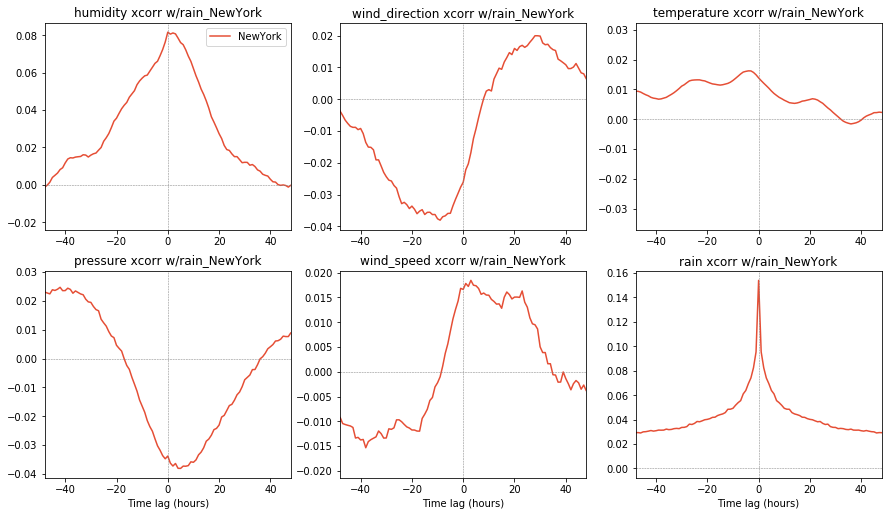

In [4]:
def plotXCorrsBetweenTarget(weatherData, targetName = 'rain_NewYork', nCols = 3):
    ''' This function takes the weather data and plots the cross correlation between 
    the factors and the target variable, which is 'rain_NewYork' by default.
    '''
    attributes = weatherData.columns[1::]
    targetVariable = weatherData[targetName]
    
    # determine cities in weatherData: 
    cities = []; 
    for i in range(len(attributes)): cities.append(attributes[i].rsplit('_',1)[1])
    cities = cities[0:int(len(cities)/6)]# 6 is the number of weather attribute types

    nAttributes = (len(attributes))//len(cities)
    nRows = ceil(nAttributes/nCols)
    
    plt.subplots(nrows = nRows, ncols = nCols, sharex='col', figsize=(15, 2*nRows))
    timeLag = range(-len(weatherData)+1,len(weatherData))
    cityColors = plt.get_cmap('RdYlGn')(np.linspace(0.15, 0.85, len(cities)))
    gridNum=100*nRows + 10* nCols 
    
    for a in range(0,nAttributes): # iterate through each attribute
        ax = plt.subplot(gridNum+a+1)
        for c, city in zip(range(len(cities)), cities): # then by city
            attribute = attributes[len(cities)*a+c]
            # calculate Xcorr between factor and the targetVariable
            xcorr=signal.correlate(weatherData[attribute],targetVariable) / len(targetVariable)       
            ax.plot(timeLag,xcorr,linestyle = '-',marker = 'None', color = cityColors[c,:], label = city)

    # Plot formatting: 
        title = attribute.rsplit('_',1)[0]
        ax.set_title(title + ' xcorr w/' + targetName)
        ax.set_xlim((-48,48))
        ax.axvline(x=0, color = 'gray', linestyle = '--', linewidth = .5)
        ax.axhline(y=0, color = 'gray', linestyle = '--', linewidth = .5)
        if a ==0:
            handles, labels = ax.get_legend_handles_labels()
            ax.legend(handles, labels, loc='best')
        elif ceil((a+1)/nCols)== nRows: 
            ax.set_xlabel('Time lag (hours)')       
    plt.subplots_adjust(bottom = -.7)
    plt.show()
    

plotXCorrsBetweenTarget(weatherData, targetName = 'rain_NewYork', nCols = 3)

Above are cross-correlograms between the factors and rain_NYC over a 96 hour window from 
the times it rained NYC. The cross-correlations or the degree to which the variables are correlated across time is on the y-axis, and on the x-axis is the time-lag between the factors and rain_NYC(t=0 is the time of rain in NYC). We can see that humidity, wind_speed,and rain itself are generally poisitively correlated with rain upcoming rain, while pressure decreases prior to rain. These are generally known phenomena to precede raid.

Wind direction also decreases (is more coutnerclockwise) and begins increasing (moves more clockwise) prior to when it rains. All in all, these cross-correlograms indicate that there are informative factors in the dataset that can potentially help us to predict rain on the next day in NYC. Next, we will format the data in a way to make this prediction (i.e. construct the feature matrix and target vector).


<a id="Create-feature-matrix"></a>

## 3: Create feature matrix and subset training, test, and validation sets <br><font size = 1>[(back to contents)](#Contents) </font><br>

Now, let's create the the feature matrix and target vector that will be used to train and
test the calssifiers to predict if it will rain the next day. 

The feature matrix will have 1851 observations (rows), one for each day from 10/2/2012 - 10/26/2017. The predictors (columns) will be the hourly values of the attributes (e.g. 
humidity, temperature, etc.). Because there are 6 hourly attributes, there will be
6 x 24 = 144 predictors. The target vector will be a binary vector of whether it rained (=1)
or not (=0) in NYC on the next calendar day.

Run the code below to construct the feature matrix and target vector:

In [5]:
def constructMLdatasets(weatherData, incl_month= False):
    ''' Creates feature matrix and target vector from temporal weather data.
    The target vector is a binary object indicating if it rained the next 
    calendar day in NYC (=1) or not (=0). 
    
    In the feature matrix, each day is an observation (row) and the features 
    are weather_attribute*hour.'''
    
    attributes = weatherData.columns
    featureNames = []
    target = []
    # create hourly attributes for each measurement type: 
    for attribute in attributes[1::]:
        for hour in range(24):
            featureNames.append(attribute + '_' + str(hour))   
    if incl_month == True:
        featureNames.append('month')
        
    featureMatrix = pd.DataFrame(columns=featureNames)
    
    observationVals = []
    for idx in range(0,weatherData.shape[0]-24,24):
        target.append(any(weatherData.rain_NewYork[idx+24:idx+48])*1)
        if idx > 0:
            dict1 = dict(zip(featureNames,observationVals))
            featureMatrix = featureMatrix.append(dict1, ignore_index=True)
        observationVals = []
        for attribute in attributes[1::]:
            for hour in range(24):
                observationVals.append(weatherData[attribute][idx+hour])
        if incl_month == True:
            observationVals.append(weatherData.datetime[idx].month)
            
    dict1 = dict(zip(featureNames,observationVals))
    featureMatrix = featureMatrix.append(dict1, ignore_index=True)
    print('Feature Matrix:')
    display(featureMatrix)
    # Convert to numpyarrays for sklearn:
    featureMatrix = featureMatrix.to_numpy()
    target = target
    return featureMatrix, target, featureNames

featureMatrix, target, featureNames = constructMLdatasets(weatherData)
print('Target vector:')
print(target)
# The feature matrix we will use to train the classifiers is displayed below as well as the 
# target vector

Feature Matrix:


,humidity_NewYork_0,humidity_NewYork_1,humidity_NewYork_2,humidity_NewYork_3,humidity_NewYork_4,humidity_NewYork_5,humidity_NewYork_6,humidity_NewYork_7,humidity_NewYork_8,humidity_NewYork_9,...,rain_NewYork_14,rain_NewYork_15,rain_NewYork_16,rain_NewYork_17,rain_NewYork_18,rain_NewYork_19,rain_NewYork_20,rain_NewYork_21,rain_NewYork_22,rain_NewYork_23
0,-0.579026,-0.629308,-0.629308,-0.629308,-0.679590,-0.679590,-0.679590,-0.679590,-0.729872,-0.729872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.031563,-1.031563,-1.031563,-0.377898,-0.579026,-0.729872,-0.579026,-0.729872,-0.176770,-0.729872,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
2,1.331690,1.683663,1.683663,1.683663,1.683663,1.683663,1.683663,1.683663,1.683663,1.331690,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.080280,1.381972,1.683663,1.683663,1.683663,1.683663,1.683663,1.482536,1.331690,1.482536,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,1.080280,1.080280,1.331690,1.080280,0.828870,1.080280,1.080280,1.683663,1.381972,1.080280,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1846,-1.383537,-1.232691,-1.081845,-0.930999,-0.729872,-0.579026,-0.930999,-0.780154,-0.780154,-0.176770,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1847,-0.176770,-0.176770,-0.176770,0.275768,0.778588,0.778588,1.080280,1.080280,1.331690,1.331690,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1848,0.527178,0.326050,0.577460,0.577460,0.828870,0.828870,0.828870,0.828870,0.828870,0.828870,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1849,1.331690,1.080280,1.381972,1.381972,1.381972,1.080280,1.331690,1.331690,1.331690,1.331690,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Target vector:
[1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 

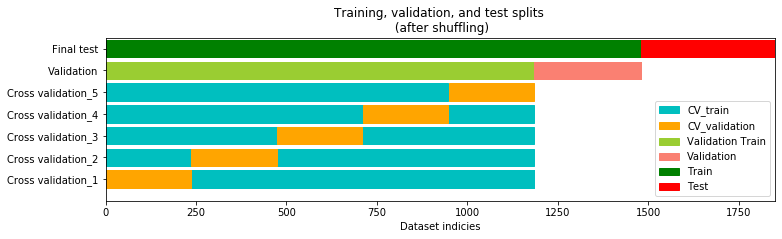

In [6]:
## Further preprocessing steps & visualizion of how data is split:

# Shuffle datasets:
X,y = utils.shuffle(featureMatrix,target, random_state = 0) 

# Split X and y into training and test sets (80% Train : 20% Test):
X_Train, X_Test, y_Train, y_Test = model_selection.train_test_split(
    X, y, random_state = 0, test_size = 0.2)
# ***** N.B. Capital T (e.g. X_Train and X_Test) indicate the final training and test data.

# Split Train sets into validation sets and training sets 
# (Of the Training set, 80% train : 20% validation):
X_train, X_val, y_train, y_val = model_selection.train_test_split(
    X_Train, y_Train, random_state = 0, test_size = 0.2)

# We will perform 5-fold cross validations for each classifier. 
# The same cross-validation indicies will be used for each classifier 
# so that model comparisons aren't based on sampling differences. 

cv=model_selection.KFold(n_splits = 5, shuffle = False)

# Visualize how the dataset was split after shuffling:

def showDataSplits(y_train, y_val,y_Train, y_Test, cv):
    ''' Helper function to show how the data was split'''
    fig, ax = plt.subplots(figsize = (12,3))
    plt.xlim(0,len(y_Train)+len(y_Test))
    plt.ylim(0,cv.n_splits+2.5)
    ax.set_title('Training, validation, and test splits \n (after shuffling)')
    plt.xlabel('Dataset indicies')
    yticklabels= []; 
    offset = -.4
    i = 0
    for train_idxs, cval_idxs in cv.split(y_train):
        # training data: 
        i += 1
        start = (min(train_idxs),i+offset)
        width = max(train_idxs)-min(train_idxs)
        if i == 1:
            ax.add_patch(mpl.patches.Rectangle(start, width = width, height = .8, color = 'c', label = 'CV_train'))
        ax.add_patch(mpl.patches.Rectangle(start, width = width, height = .8, color = 'c'))
        # cross-validation data: 
        start = (min(cval_idxs),i+offset)
        width = max(cval_idxs)-min(cval_idxs)
        if i == 1:
            ax.add_patch(mpl.patches.Rectangle(start, width = width, height = .8, color = 'orange', label = 'CV_validation')) 
        ax.add_patch(mpl.patches.Rectangle(start, width = width, height = .8, color = 'orange'))
        yticklabels.append('Cross validation_' + str(i))
    
    # Validation set:
    start = (0,cv.n_splits+1+offset)
    width = len(y_Train)
    ax.add_patch(mpl.patches.Rectangle(start, width = width, height = .8, color = 'yellowgreen', label = 'Validation Train')) 
    start = (len(y_train),cv.n_splits+1+offset)
    width = len(y_val)
    ax.add_patch(mpl.patches.Rectangle(start, width = width, height = .8, color = 'salmon', label = 'Validation')) 
    yticklabels.append('Validation')
    
    # Final Training and Test sets: 
    start = (0,cv.n_splits+2+offset)
    width = len(y_Train)
    ax.add_patch(mpl.patches.Rectangle(start, width = width, height = .8, color = 'g', label = 'Train')) 
    start = (len(y_Train),cv.n_splits+2+offset)
    width = len(y_Train)
    ax.add_patch(mpl.patches.Rectangle(start, width = width, height = .8, color = 'r', label = 'Test')) 
    yticklabels.append('Final test')
    
    #Format plot
    plt.yticks(np.arange(1,cv.n_splits+3),yticklabels)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    plt.show()


showDataSplits(y_train, y_val,y_Train, y_Test, cv)


<a id="Background-and-rationale"></a>
## 4: Background and rationale for classification methodologies <font size = 1>[(back to contents)](#Contents) </font><br>     

We'll use 3 classifiers in this excercies. The baseline version is logistic regression, 
which is a class of generalized linear models (GLMs), where a linear combination of the 
predictors will be used to predict if it will rain tomorrow. Because the target 
is binary and not coninuous, the mapping will occur through a logit link function. This
is a very interpretable model, as the coeffcients for each predictor gives an impression 
of how strong the predictor is. However, it suffers from being unable to account for 
complex interaction effects.

We'll next use a K-nearest neighbors (KNN) classifier, which will make predictions based on 
days with similar attributes in the past. If we think rain tomorrow is based on the 
attributes of today, than it can be logical to look back in history and find similar
days in the past to predict the probablity of rain for the next day based upon today's 
attributes. This alogrithm predicts the probablity of rain the next day based on the 
k-nearest neighbors (we'll use Euclidean distance) from the training data. This methodology 
would work best if rainy days and non-rainy days formed well-defined clusters in high-
dimensional space, but it would suffer if the data is widely spread out. We'll estimate a
value of k to minimize error rates from a bias-variance plot.

The last classifer we will utilize is the random forest classifier. This algorithm  
creates an ensemble of decision trees, where branches were generated by the predictor that
best classified if it would rain or not out of a random subset of predictors. Each decision 
tree was constructed based on how it classified a bootstrapped sample of the training data 
with replacement (bagging), which is meant to reduce the problem of over-fitting. This 
method is meant to be able to account for complex interactions between factors which could
predict if it will rain or not the next day in NYC. 

While rain in NYC tomorrow may be reflected in the NYC's conditions today, we saw from the 
cross-correlograms that the predictive power of the attributes are transient. Weather 
obviously travels (typically south to north around NYC) and it takes time to travel. 
Leveraging weather data from the Midwest and Eastern US cities could extend our prediction i
interval and thus enhance our ability to predict if it will rain in NYC the next day. Thus, 
we'll do some feature engineering by incorporating data from 'NewYork', 'Philadelphia',
'Detroit', and 'Nashville'. We'll also incorporate other features like the derivative of 
weather measurements because the changes in weather conditions could help us predict rain. 
We'll also add month of the year because rain in more common in summer months in NYC. We'll 
use this engineerd matrix to train a random forest classifier.

In order to compare performance between calssifiers, we'll compare the cross-validated area
under the curve of ROC curves (ROC_AUC). ROC_AUC is a common measure of how well the 
classifier is able to distinguish between classes - the higher the better. This is a better 
representation of classifier performance than accuracy, especially when there are skewed 
distributions of the target class, as in our case (~60% of days are rainy). Moreover,
accuracy is highly dependant on the classification threshold, which is a hyperparemeter I 
could adjust to account for inherent biases in the classifiers. In the end, we can compare
accuracy on the validation and test datasets.

The functions below will be used to plot the ROC curves for classifiers and tabulate ROC_AUC as we go:


In [7]:
def plotROC(clf,X_train=X_train,y_train=y_train, cv=cv):
    y_train_array = np.array(y_train)
    plt.figure()
    i = 0
    AUC = []
    for train_idxs, cval_idxs in cv.split(X_train):
        mdl = clf.fit(X_train[train_idxs],y_train_array[train_idxs])
        y_score = mdl.predict_proba(X_train[cval_idxs])[:,1]
        fpr, tpr, threshold = metrics.roc_curve(y_train_array[cval_idxs], y_score, drop_intermediate = False)
        AUC.append(metrics.auc(fpr, tpr))
        plt.plot(fpr, tpr, linewidth = .75, label='ROC curve (area = %0.2f)' % AUC[i])
        i += 1
    # Annotate plot
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve, mean AUC = %.4f' % np.mean(AUC))
    plt.legend(loc="lower right")
    plt.show()

# The function below will be utlized to tabulate ROC_AUC as we go:
AUC_scores = {}
def evalROC_AUC(clf, method, X_train=X_train, y_train=y_train, AUC_scores = AUC_scores):
    if method in list(AUC_scores.keys()): 
        print('Already assessed performance of ' + method)
        return
    AUC_scores[method] = model_selection.cross_val_score(clf, X_train, y_train, cv=cv, scoring = 'roc_auc');
    return AUC_scores


<a id="Baseline-version"></a>

## 5: Baseline version: Logistic regression <font size = 1>[(back to contents)](#Contents) </font><br>

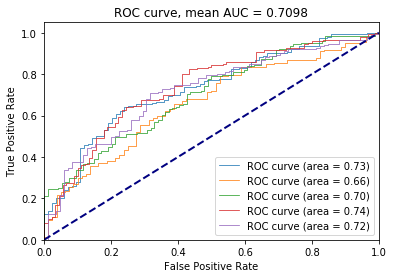

In [8]:
method = 'logisticRegression'
clf = linear_model.LogisticRegression(random_state=0, solver = 'liblinear',
                                      multi_class = 'ovr', max_iter=500)
AUC_scores = evalROC_AUC(clf,method, AUC_scores = AUC_scores)
baselineMdl = clf.fit(X_train,y_train)

# This is the first classifier, so let's ensure that it is properly working by examining
# the cross-validated ROC curves: 
plotROC(clf)

The ROC curves are all above the diagonal indicating that the classifier is classifying better than chance. We'll compare the mean cross-validated AUC for all classifiers later.

<a id="Cutoff-plots"></a>
### Cutoff plots:
Logistic regression is a parametric approach because it assumes that a linear combination of the predictors can predict if it will rain the next day through mapping to a logit link function. This assumption can introduce biases such that the theoretical p>0.5 may be a suboptimal classification threshold. All classifiers are subject to some degree of bias, so  it can be useful to visualize the impact of classification threshold on accuracy, which we  can do using cutoff plots - mean cross-validated accuracy vs. threshold. The function below generates these cutoff plots for a classifier as shown below. 


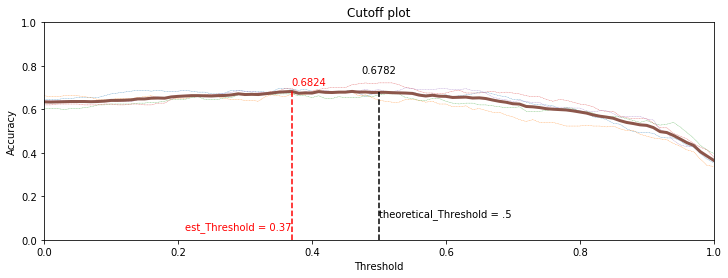

In [9]:
def plotCutoff(clf,X_train=X_train,y_train=y_train, cv=cv):
    nThresholds = 101
    thresholds = np.linspace(0,1,nThresholds)
    y_train_array = np.array(y_train)

    fig, ax = plt.subplots(figsize = (12,4))
    i = 0
    allAccuracy = np.array([])
    for train_idxs, cval_idxs in cv.split(X_train):    
        mdl = clf.fit(X_train[train_idxs],y_train_array[train_idxs])
        y_score = mdl.predict_proba(X_train[cval_idxs])[:,1]
        cvAccuracy = np.array([])
        for threshold in thresholds:
            accuracy = sum((y_score > threshold) == y_train_array[cval_idxs])/len(y_train_array[cval_idxs])
            cvAccuracy = np.append(cvAccuracy, accuracy)
        plt.plot(thresholds, cvAccuracy, linestyle = '--', linewidth = .3)
        allAccuracy = np.append(allAccuracy,cvAccuracy)
    meanAccuracy = np.mean(allAccuracy.reshape(cv.n_splits,nThresholds),axis = 0)
    plt.plot(thresholds,meanAccuracy,linewidth = 3)

    ## Annotate plot:
    yOffset = +.03
    xOffset = 0
    maxAccuracy = meanAccuracy[meanAccuracy.argmax()]
    est_Threshold = thresholds[meanAccuracy.argmax()]   

    plt.plot([est_Threshold, est_Threshold],[0, maxAccuracy], linestyle = '--', color = 'r')    
    plt.annotate('est_Threshold = %.2f'% est_Threshold, (est_Threshold-2*xOffset, .05), ha = 'right', color = 'r')
    plt.annotate('%.4f'% maxAccuracy, (est_Threshold-xOffset, maxAccuracy+yOffset), color = 'r')

    accuracy_at_50p = meanAccuracy[int(nThresholds/2)];
    plt.plot([.5, .5],[0, accuracy_at_50p], linestyle = '--', color = 'k')    
    plt.annotate('%.4f'% accuracy_at_50p, (.5+xOffset, accuracy_at_50p+3*yOffset), ha = 'center')
    plt.annotate('theoretical_Threshold = .5', (.5+xOffset, .05+2*yOffset))

    plt.xlim(0,1)
    plt.ylim(0,1)
    ax.set_title('Cutoff plot')
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.show()
    return
    
plotCutoff(clf)

From the cutoff plot, we can see that if our thershold was lower it could improve  classifiaction accuracy slightly. The landscape looks fairly flat, meaning that  the threshold parameter won't likely change classification accuracy to a great degree.  We will just use the default threshold of p>0.5 moving forward. 


This model is highly interpretable, with the magnitude of the coefficients indicating how much each factor relatively contributes to the predicting rain. We see that the coefficients are generally large toward the ends of the day. For example, the rain at 10 and 11pm (the last two bars below) has a high predictive power of whether it will rain the next day. 

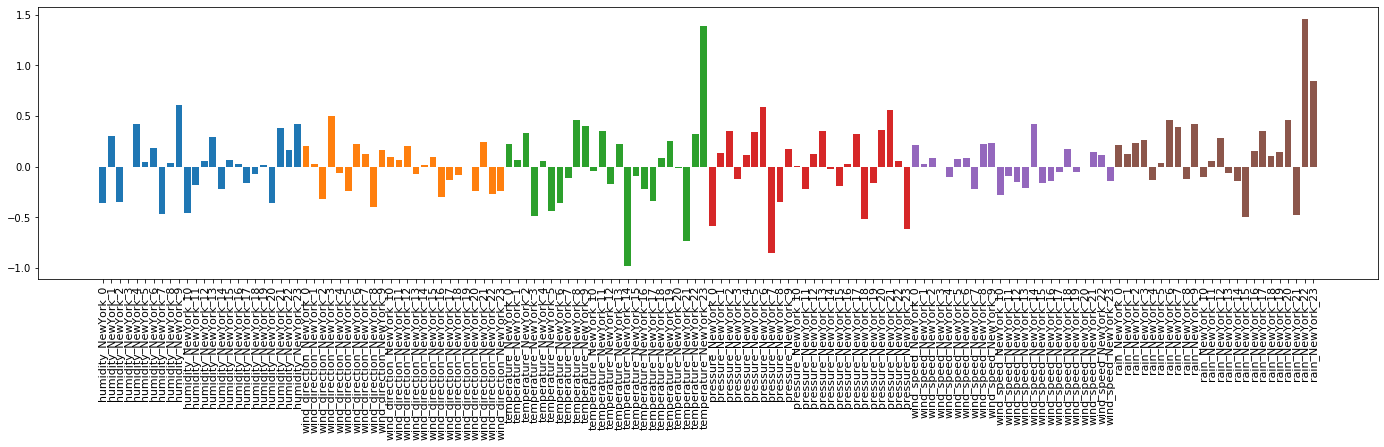

In [10]:
plt.subplots(figsize=(24, 5))
for idx in range (0,144,24):
    plt.bar(featureNames[idx:idx+24],baselineMdl.coef_[0][idx:idx+24])
    plt.xticks(rotation=90, fontsize = 11)
plt.show()

<a id="Version-1"></a>

##     6: Version 1: KNN classifier <font size = 1>[(back to contents)](#Contents) </font><br>

Next, we'll train a KNN classifier. 

<a id="Bias-variance-plot"></a>
### Bias-variance plot:
This classifier is highly sensitive to what we define as K - the number of neighbors based upon which we will predict the probablity of rain in NYC tomorrow. Generally, the lower the K, the more likely we are to overfit our data (more variance). We'll generate a bias-variance plot with mean cross-validated error rates on the y-axis and 1/K on the x-axis and choose the K that seems to minimizes the mean cross-validated error rates. Note: as 1/K increases, so does the 'variance' in our model, which leads to overfitting the model and higher test error rates. Let's make the plot below:

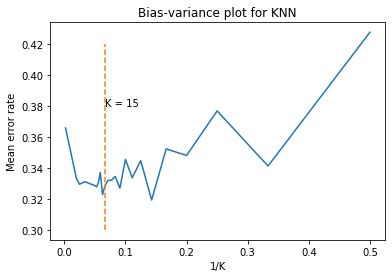

In [11]:
def plotBiasVariance_Knn(X_train=X_train, y_train=y_train, cv = cv):
    Ks = np.array([2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,30,40,50,500])
    y_train_array = np.array(y_train)
    error_rate = []
    i = 0
    for K in Ks:
        cv_error = []
        for train_idxs, cval_idxs in cv.split(X_train):   
            clf = neighbors.KNeighborsClassifier(n_neighbors=K)
            mdl = clf.fit(X_train[train_idxs],y_train_array[train_idxs])
            y_predict = mdl.predict(X_train[cval_idxs])
            cv_error.append(sum(y_predict != y_train_array[cval_idxs])/len(y_train_array[cval_idxs]))
        error_rate.append(np.mean(cv_error))
        i +=1

    # Annotate plot:
    plt.figure()
    plt.plot(1/Ks,error_rate)
    plt.plot([1/15, 1/15],[.30, .42],ls = '--')
    plt.annotate('K = 15',(1/15, .38), ha = 'left')
    plt.xlabel('1/K')
    plt.ylabel('Mean error rate')
    plt.title('Bias-variance plot for KNN')
    plt.show()
    
plotBiasVariance_Knn()    


The plot above shows that K = 15 seems like it strikes a good balance between bias error
and variance error, so we'll use K = 15 for the KNN classifier. As before, we will examine 
the ROC curves and cutoff plots. 

Cross-validated performance of KNN


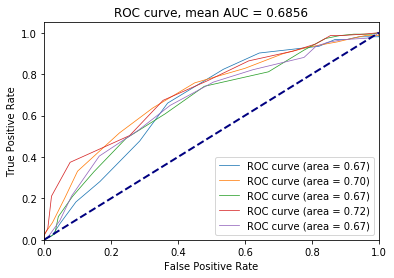

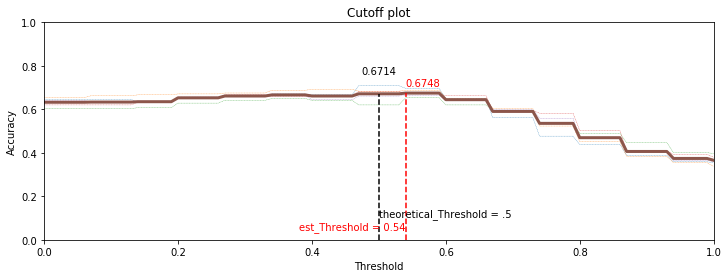

In [12]:
method = 'KNN'
clf = neighbors.KNeighborsClassifier(n_neighbors=15)
print('Cross-validated performance of ' + method)
plotROC(clf)
plotCutoff(clf)
AUC_scores = evalROC_AUC(clf,method, AUC_scores = AUC_scores)
mdl1 = clf.fit(X_train,y_train)

The mean AUC is slightly lower than baseline .6856 vs .7098, and the cutoff plot suggest 
simliar accuracy around 67%. The estimated threshold is identical to the theoretical 
threshold, which is a good sanity check. 

<a id="Version-2"></a>
## 7: Version 2 - Random Forest classifier <font size = 1>[(back to contents)](#Contents) </font><br>
The random forest classifer has many hyper-paramters that we can adjust like minimum leaf size and the number of random predictors to choose splits from (max_features). An important consideration would be to make sure the number of decision trees is large enough. Theoretically, classification performance imporves with more trees; however, if the forest gets too large, this becomes computationally intractable for marignal gains.

Next, we'll see how to determine if we have a proper forest size. The random forest algorithm works by iteratively adding decision trees to classify a bootstrapped sample of the training data; thus, we can examine the misclassification error on the out-of-bag (OOB) set of observations each time a new tree is added. This serves as a method for cross validation and forevaluating if our forest is 'large enough'. We'll do this by growing the random forest on the training data and plotting the OOB error rates vs. forest size below:

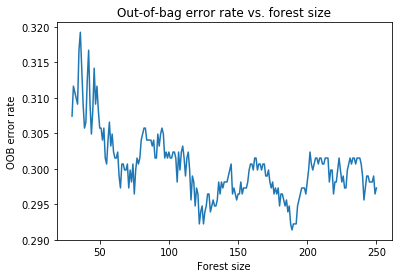

In [13]:
clf = ensemble.RandomForestClassifier(random_state=0, 
                                      max_features = 'auto', min_samples_leaf = 10)
def plotOOBerror(clf, max_estimators = 250, X_train= X_train, y_train= y_train):
    oob_error = []
    numEstimators = list(range(30, max_estimators + 1))
    for i in numEstimators:
        clf.set_params(n_estimators=i, warm_start=True, oob_score=True)
        clf.fit(X_train, y_train)
        # Record the OOB error for each forest size
        oob_error.append(1 - clf.oob_score_)

    plt.figure()
    plt.plot(numEstimators,oob_error)
    plt.title('Out-of-bag error rate vs. forest size')
    plt.xlabel('Forest size')
    plt.ylabel('OOB error rate')
    plt.show()
    
plotOOBerror(clf, max_estimators = 250)

The performance of this classifier plateaus after a forest size of about 150 decision trees. We can train the classifier on the entire training set using 250 trees:

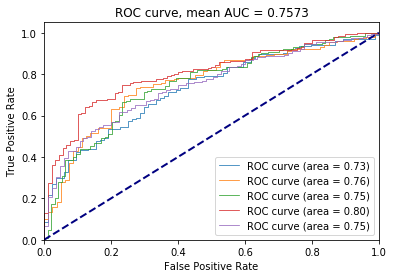

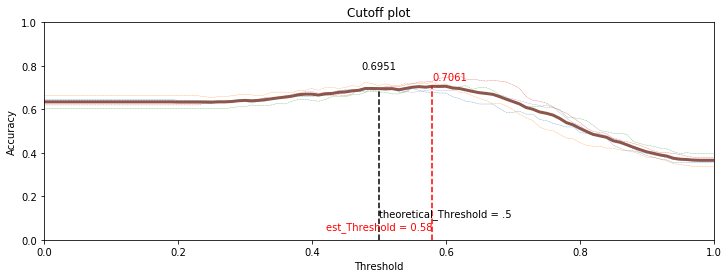

In [14]:
method = 'RandomForest'
clf = ensemble.RandomForestClassifier(n_estimators = 250, random_state=0, 
                                      max_features = 'auto', min_samples_leaf = 5)
plotROC(clf)
plotCutoff(clf)
AUC_scores = evalROC_AUC(clf,method, AUC_scores = AUC_scores)
# Train the classifier.
mdl2 = clf.fit(X_train, y_train)


The mean AUC for the random forest classifier (0.7573) is greater than for the baseline and KNN (.7098 and .6856, respectively) and the accuracy is slightly higher too (69.51% vs. 67.82 and 67.14%, respectively).

<a id="Feature-engineering"></a>
## 8: Feature engineering <font size = 1>[(back to contents)](#Contents) </font><br>
The random forest classifier should be a great method to account for complex interactions. We may be approaching the limits of performance based on the feature matrix. Thus, this may be a good time to incorporate other data into the feature matrix, or what we call feature engineering. Feature engineering can be an iterative cycle with the validation step (which I'll show below), but the more we iterate, the more we'd be overfitting. The feature engineering steps were done in an iterative process, but I'll present all the feature engineering steps I took below starting with incorporating data from different cities:

In [15]:
cities = ['NewYork', 'Philadelphia','Detroit','Nashville']
weatherData2 = getWeatherData(cities = cities)

,datetime,humidity_NewYork,humidity_Philadelphia,humidity_Detroit,humidity_Nashville,wind_direction_NewYork,wind_direction_Philadelphia,wind_direction_Detroit,wind_direction_Nashville,temperature_NewYork,...,pressure_Detroit,pressure_Nashville,wind_speed_NewYork,wind_speed_Philadelphia,wind_speed_Detroit,wind_speed_Nashville,rain_NewYork,rain_Philadelphia,rain_Detroit,rain_Nashville
0,2012-10-02 00:00:00,-0.579026,-0.158463,-0.124884,1.464065,0.630695,0.772224,-1.960119,-1.065827,0.356155,...,-0.428304,-1.857050,1.274213,-0.340505,-1.642555,0.906662,0,0,0,0
1,2012-10-02 01:00:00,-0.629308,-0.158463,-0.179102,1.413336,0.630695,0.781996,-1.960119,-1.065827,0.363909,...,-0.428304,-1.857050,1.274213,-0.340505,-1.642555,0.906662,0,0,0,0
2,2012-10-02 02:00:00,-0.629308,-0.211521,-0.233319,1.413336,0.640003,0.801541,-1.949853,-1.065827,0.371663,...,-0.428304,-1.857050,1.274213,-0.340505,-1.642555,0.906662,0,0,0,0
3,2012-10-02 03:00:00,-0.629308,-0.211521,-0.233319,1.413336,0.640003,0.811313,-1.949853,-1.065827,0.379417,...,-0.428304,-1.857050,1.274213,-0.340505,-1.642555,0.906662,0,0,0,0
4,2012-10-02 04:00:00,-0.679590,-0.264579,-0.287537,1.362607,0.640003,0.821085,-1.949853,-1.065827,0.387171,...,-0.428304,-1.857050,1.274213,-0.340505,-1.642555,0.906662,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44443,2017-10-27 19:00:00,-1.685229,-1.537973,-0.775494,0.449486,-1.826507,-0.126833,0.154688,0.865247,0.448081,...,-1.147781,-1.176604,-1.009487,0.206984,0.953590,0.332557,0,0,0,0
44444,2017-10-27 20:00:00,-1.534383,-1.537973,-0.341754,0.703131,-1.826507,-0.322280,0.052027,1.058354,0.448081,...,-1.147781,-1.176604,-0.096007,0.754473,0.434361,0.332557,0,0,0,0
44445,2017-10-27 21:00:00,-1.433819,-1.219624,-0.341754,0.703131,-1.826507,-0.322280,0.257348,1.154908,0.399168,...,-1.044999,-1.176604,-1.009487,0.754473,0.434361,0.906662,0,0,0,0
44446,2017-10-27 22:00:00,-0.629308,-1.060450,0.200421,0.956776,-0.002220,-0.420003,0.667991,1.541122,0.246559,...,-1.147781,-1.176604,-0.552747,0.206984,1.472819,2.054872,0,0,0,0


Now, we'll examine temporal correlations between weather attributes in these cites and rain in NYC like we did before to see if we were getting meaningful data from the other cities:

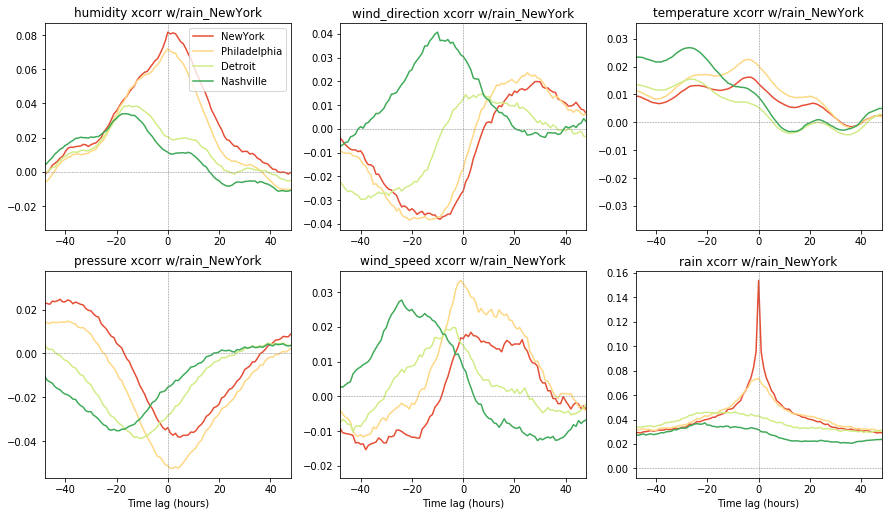

In [16]:
plotXCorrsBetweenTarget(weatherData2, targetName = 'rain_NewYork', nCols = 3)

These cross-correlograms indicate there are are indeed temporal correlation between weather in other cities and rain in NYC. For instance, in the top left panel, we see that humidity increasing ~40 hours earlier is correlated to rain in NYC at t=0. The bottom center panel shows strong temporal correlations with wind speeds in Nashville ~24 hours prior to rain in NYC. I specifically chose cities south and west of NYC that seem to provide decorrelated information that could be helpful for our classification problem at hand. 


<a id="Incorporating-derivatives"></a>
### Incorporating derivatives:
These cross-correlograms indicate that it's not necessarily absolute values but how they are changing which could predict rain. Thus, we can incorporate derivatives of the predictors and use them as predictors. Let's also look at how changes in weather features are cross-correlated to rain in NYC:

,datetime,humidity_deriv_NewYork,humidity_deriv_Philadelphia,humidity_deriv_Detroit,humidity_deriv_Nashville,wind_direction_deriv_NewYork,wind_direction_deriv_Philadelphia,wind_direction_deriv_Detroit,wind_direction_deriv_Nashville,temperature_deriv_NewYork,...,pressure_deriv_Detroit,pressure_deriv_Nashville,wind_speed_deriv_NewYork,wind_speed_deriv_Philadelphia,wind_speed_deriv_Detroit,wind_speed_deriv_Nashville,rain_NewYork,rain_Philadelphia,rain_Detroit,rain_Nashville
0,2012-10-02 00:00:00,-0.003392,0.000000,-0.003657,-0.003422,0.000000,0.000659,0.000000,0.000000,0.000523,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0
1,2012-10-02 01:00:00,-0.010660,-0.003579,-0.015152,-0.010755,0.000628,0.003390,0.000692,0.000000,0.002167,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0
2,2012-10-02 02:00:00,-0.014176,-0.011249,-0.026780,-0.014302,0.001973,0.007558,0.002177,0.000000,0.004353,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0
3,2012-10-02 03:00:00,-0.015194,-0.018538,-0.031669,-0.015329,0.002624,0.010535,0.002894,0.000000,0.006173,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0
4,2012-10-02 04:00:00,-0.018298,-0.023703,-0.032457,-0.018461,0.002813,0.011558,0.003102,0.000000,0.007351,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44443,2017-10-27 19:00:00,-0.190013,-0.180862,-0.033525,0.151443,-0.348599,-0.008182,0.000556,0.190361,0.101633,...,0.040023,-0.079741,0.012546,0.191444,0.115263,-0.489949,0,0,0,0
44444,2017-10-27 20:00:00,-0.102747,-0.046381,0.015126,0.246679,-0.233915,-0.041716,-0.019124,0.222243,0.057709,...,0.035908,-0.076083,0.107166,0.174293,0.127592,-0.301879,0,0,0,0
44445,2017-10-27 21:00:00,0.039011,0.075334,0.096959,0.253653,-0.000400,-0.064080,0.026387,0.227542,0.007112,...,0.031453,-0.054044,0.086499,0.120185,0.133279,0.012116,0,0,0,0
44446,2017-10-27 22:00:00,0.229458,0.183990,0.217953,0.222310,0.326522,-0.069205,0.086529,0.213926,-0.053373,...,0.028061,-0.015064,0.085439,-0.045372,0.099665,0.254643,0,0,0,0


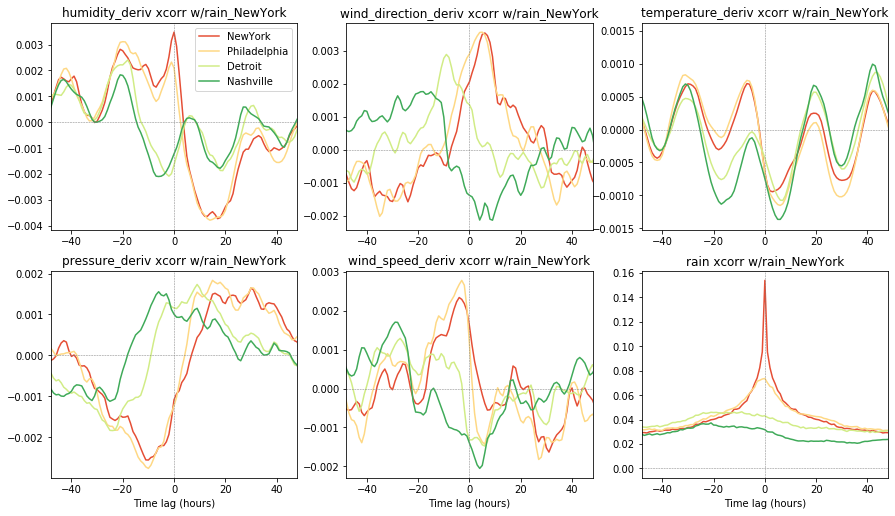

In [17]:
cities = ['NewYork', 'Philadelphia','Detroit','Nashville']
weatherDataDeriv = getWeatherData(cities = cities, extractRain = True, deriv = True)
plotXCorrsBetweenTarget(weatherDataDeriv, targetName = 'rain_NewYork', nCols = 3)

There are interesting patterns in the derivatives of these features that could help classify if it will rain or not, so we'll add these derivatives into our feature matrix as well. We could potentially select certain features since adding features that add no further value generally serves to make the model worse by introducing noise. For the purpose of this exercise I chose to add all the data as is. 


In [18]:
weatherData2 = pd.concat([weatherData2,weatherDataDeriv],axis = 1)
# Remove redundant rain columns: 
weatherData2 = weatherData2.loc[:,~weatherData2.columns.duplicated()]

The last feature we will incorporate is the month of the year. As you can see below, there is a higher probablity of a rain day in the middle of the year.

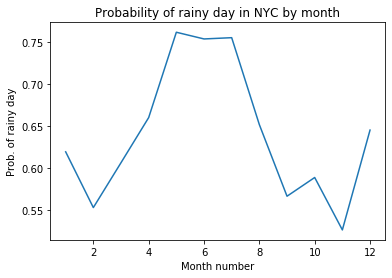

In [19]:
months = pd.DatetimeIndex(weatherData2.datetime).month
rain_NYC = []
month = []
for idx in range(0,weatherData2.shape[0]-24,24):
    rain_NYC.append(any(weatherData.rain_NewYork[idx+24:idx+48])*1)
    month.append(months[idx])

rain_NYC = np.array(rain_NYC)
month = np.array(month)
pRain = []
for m in range(1,13): 
    pRain.append(sum(rain_NYC[month==m])/sum(month==m))
plt.plot(np.arange(1,13),pRain)
plt.xlabel('Month number')
plt.ylabel('Prob. of rainy day')
plt.title('Probability of rainy day in NYC by month')
plt.show()

Next, we'll preprocess the data in the same way we did before, except we'll also incorporate the month: 

Feature Matrix:


,humidity_NewYork_0,humidity_NewYork_1,humidity_NewYork_2,humidity_NewYork_3,humidity_NewYork_4,humidity_NewYork_5,humidity_NewYork_6,humidity_NewYork_7,humidity_NewYork_8,humidity_NewYork_9,...,wind_speed_deriv_Nashville_15,wind_speed_deriv_Nashville_16,wind_speed_deriv_Nashville_17,wind_speed_deriv_Nashville_18,wind_speed_deriv_Nashville_19,wind_speed_deriv_Nashville_20,wind_speed_deriv_Nashville_21,wind_speed_deriv_Nashville_22,wind_speed_deriv_Nashville_23,month
0,-0.579026,-0.629308,-0.629308,-0.629308,-0.679590,-0.679590,-0.679590,-0.679590,-0.729872,-0.729872,...,-0.154906,-0.486865,-0.647438,-0.539030,-0.271385,-0.010222,0.061618,0.113374,0.181601,10.0
1,-1.031563,-1.031563,-1.031563,-0.377898,-0.579026,-0.729872,-0.579026,-0.729872,-0.176770,-0.729872,...,0.000020,-0.169295,-0.116056,0.130867,0.197487,0.132975,0.109191,-0.046268,-0.252863,10.0
2,1.331690,1.683663,1.683663,1.683663,1.683663,1.683663,1.683663,1.683663,1.683663,1.331690,...,0.020103,0.211910,0.388817,0.473112,0.380254,0.161868,-0.049410,-0.200747,-0.325232,10.0
3,1.080280,1.381972,1.683663,1.683663,1.683663,1.683663,1.683663,1.482536,1.331690,1.482536,...,0.341666,0.264384,0.083692,0.025247,-0.121871,-0.265897,-0.253607,-0.180105,-0.101167,10.0
4,1.080280,1.080280,1.331690,1.080280,0.828870,1.080280,1.080280,1.683663,1.381972,1.080280,...,0.243625,0.447415,0.526997,0.417654,0.143646,-0.085677,-0.157224,-0.221789,-0.343504,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1846,-1.383537,-1.232691,-1.081845,-0.930999,-0.729872,-0.579026,-0.930999,-0.780154,-0.780154,-0.176770,...,0.357451,0.373184,0.511344,0.507858,0.214483,-0.158127,-0.385454,-0.452744,-0.397088,10.0
1847,-0.176770,-0.176770,-0.176770,0.275768,0.778588,0.778588,1.080280,1.080280,1.331690,1.331690,...,0.380497,0.181701,0.166790,0.115632,-0.014139,-0.063894,-0.144646,-0.293857,-0.392342,10.0
1848,0.527178,0.326050,0.577460,0.577460,0.828870,0.828870,0.828870,0.828870,0.828870,0.828870,...,0.274242,0.291978,0.143065,0.004265,0.023270,0.141016,0.112846,-0.277768,-0.557699,10.0
1849,1.331690,1.080280,1.381972,1.381972,1.381972,1.080280,1.331690,1.331690,1.331690,1.331690,...,0.248892,0.314022,0.488536,0.428758,0.133489,-0.101870,-0.132814,-0.148478,-0.308513,10.0


Data was split the same way: True


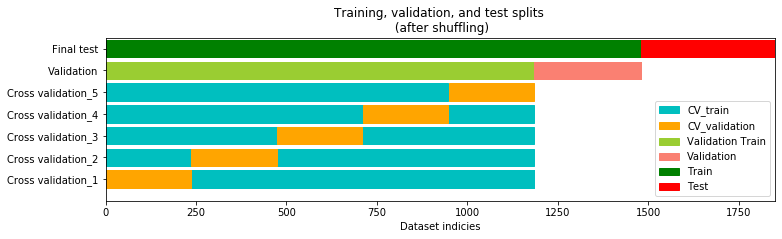

In [20]:
featureMatrix2, target2, _ = constructMLdatasets(weatherData2, incl_month = True) 

# Shuffle datasets:
X,y = utils.shuffle(featureMatrix2,target2, random_state = 0) 

# Split X and y into training and test sets (80% Train : 20% Test):
X_Train2, X_Test2, y_Train2, y_Test2 = model_selection.train_test_split(
    X, y, random_state = 0, test_size = 0.2)
# ***** N.B. Capital T (e.g. X_Train2 and X_Test2) indicate the final training and test data.

# Split Train sets into validation sets and training sets 
# (Of the Training set, 80% train : 20% validation):
X_train2, X_val2, y_train2, y_val2 = model_selection.train_test_split(
    X_Train2, y_Train2, random_state = 0, test_size = 0.2)

# Ensure we split the datasets the same exact way:
print('Data was split the same way: ' + str(y_Test2 == y_Test))

showDataSplits(y_train2, y_val2,y_Train2, y_Test2, cv)

With all the data that is now included, we have 1057 cloumns rather 144. <br><br>
Next, we'll the random forest classifier again with the new (larger) feature matrix:

<a id="Version-3"></a>
## 9: Version 3 - Random Forest classifier with engineered feature matrix <br><font size = 1>[(back to contents)](#Contents) </font><br>

Again, we can compute the OOB-error rate vs. forest size: 

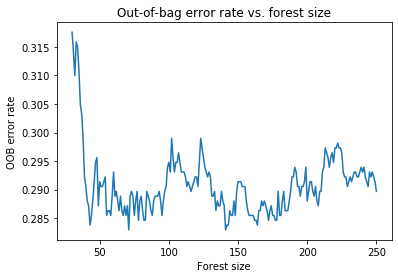

In [21]:
clf = ensemble.RandomForestClassifier(random_state=0, 
                                      max_features = 'auto', min_samples_leaf = 5)
plotOOBerror(clf, X_train = X_train2, y_train = y_train2, max_estimators = 250)


Let's again look at the standard performance metrics and train the final classifier: 

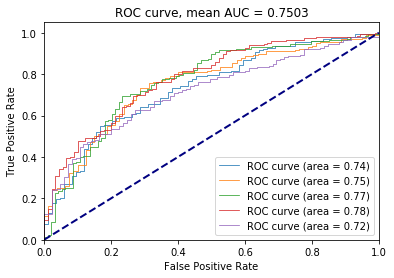

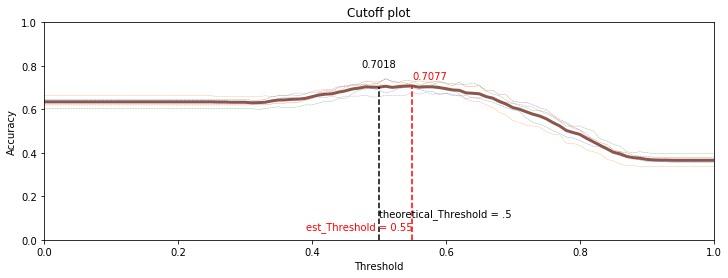

In [22]:
method = 'RandomForest_on_engDataset'
clf = ensemble.RandomForestClassifier(n_estimators = 250, random_state=0, 
                                      max_features = 'auto', min_samples_leaf = 10)

plotROC(clf, X_train = X_train2, y_train = y_train2)
plotCutoff(clf, X_train = X_train2, y_train = y_train2)
AUC_scores = evalROC_AUC(clf,method, AUC_scores = AUC_scores)
# Train the classifier.
mdl3 = clf.fit(X_train2, y_train2)

Unfortunately, the AUC looks similar and accuracy after feature engineering using the random forest classifier.

Below is the summary of the classification performance thus far (AUC scores):

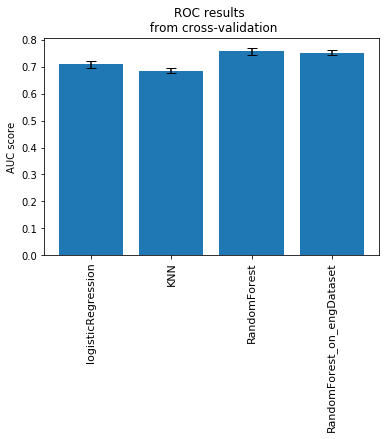

In [23]:
methods = list(AUC_scores.keys())
val = []
err = []
for m in methods:
    val.append(np.mean(AUC_scores[m]))
    err.append(stats.sem(AUC_scores[m]))
plt.bar(methods, val, yerr = err, capsize = 5)
plt.title('ROC results \n from cross-validation')
plt.ylabel('AUC score')
plt.xticks(rotation=90, fontsize = 11)
plt.show()

<a id="Validation-performance"></a>
## 10: Performance of classifiers on the validation set <font size = 1>[(back to contents)](#Contents) </font><br>

We can now evaluate the performace of the classifiers on the validation set.


In [24]:
acc0 = sum(baselineMdl.predict(X_val)==y_val)/len(y_val)*100
acc1= sum(mdl1.predict(X_val)==y_val)/len(y_val)*100
acc2= sum(mdl2.predict(X_val)==y_val)/len(y_val)*100
acc3= sum(mdl3.predict(X_val2)==y_val)/len(y_val)*100

print('Accuracy of classifiers on VALIDATION set \n------------------------------------')
print('BaselineMdl : %.5f' %acc0 +'%')
print('KNN : %.5f' %acc1 +'%')
print('Random forest : %.5f' %acc2 +'%')
print('Random forest with feature engineering : %.5f' %acc3 +'%')

Accuracy of classifiers on VALIDATION set 
------------------------------------
BaselineMdl : 67.22973%
KNN : 70.27027%
Random forest : 73.98649%
Random forest with feature engineering : 75.33784%


It seems like we have a gradual progression in the accuracy of our classifiers on the validation set!

<a id="Test-performance"></a>

## 11: Performance of classifiers on the test dataset  <font size = 1>[(back to contents)](#Contents) </font><br>
Last, but not least, we can retrain the classifiers on the entire Training set and examine their accuracy on the Test set: 

In [25]:
baselineMdl.fit(X_Train, y_Train)
mdl1.fit(X_Train, y_Train)
mdl2.fit(X_Train, y_Train)
mdl3.fit(X_Train2, y_Train2)

acc0 = sum(baselineMdl.predict(X_Test)==y_Test)/len(y_Test)*100
acc1= sum(mdl1.predict(X_Test)==y_Test)/len(y_Test)*100
acc2= sum(mdl2.predict(X_Test)==y_Test)/len(y_Test)*100
acc3= sum(mdl3.predict(X_Test2)==y_Test2)/len(y_Test2)*100

print('Accuracy of classifiers on TEST set \n------------------------------')
print('BaselineMdl : %.5f' %acc0 +'%')
print('KNN : %.5f' %acc1 +'%')
print('Random forest : %.5f' %acc2 +'%')
print('Random forest with feature engineering : %.5f' %acc3 +'%')

Accuracy of classifiers on TEST set 
------------------------------
BaselineMdl : 70.61995%
KNN : 66.84636%
Random forest : 72.77628%
Random forest with feature engineering : 72.23720%


In the final analysis, we still had the best performance with the random forest classifiers, but unfortunately, feature engineering did not seem to help. We could have tweaked hyper-parameters more to boost accuracy, but likely we'd need different types and data based on things like weather modeling and simulations. 